In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import preprocessing

from sklearn.model_selection import TimeSeriesSplit

import time

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('BTCUSDKraken.csv', index_col=0, usecols=['Date','Volume (BTC)', 'Weighted Price'])
df = df.drop('2018-01-12')
df = df.replace([0], np.nan)
df = df.ffill(axis=None, inplace=False, limit=None, downcast=None)
lookback = 3

delta = df['Weighted Price'].diff()
dUp, dDown = delta.copy(), delta.copy()
dUp[dUp < 0] = 0
dDown[dDown > 0] = 0

RolUp = pd.rolling_mean(dUp, lookback)
RolDown = pd.rolling_mean(dDown, lookback).abs()

df['RSI'] = RolUp / RolDown

sma = pd.rolling_mean(df['Weighted Price'], window = lookback, min_periods = lookback)
ema = pd.ewma(df['Weighted Price'], span = lookback, min_periods = lookback)
rolling_std = pd.rolling_std(df['Weighted Price'], window = lookback, min_periods = lookback)
up = (rolling_std * 2) + ema
down = (rolling_std * -2) + ema

#df['Price/SMA'] = df['Weighted Price']/sma
df['bbp'] = (df['Weighted Price'] - down) / (up - down)
df['Price/EMA'] = df['Weighted Price'] / ema
df['price_momentum'] = df['Weighted Price'].pct_change(periods = lookback - 1)
df['vol_momentum'] = df['Volume (BTC)'].pct_change(periods = lookback - 1)
df['bestaction'] = df['Weighted Price'].pct_change(periods = 1)

# suggestion_conditions = [
#     (df['Price/EMA'] < 0.97) & (df['bbp'] < 0.25),
#     (df['Price/EMA'] > 1.01) & (df['bbp'] > 0.75)]

actual_conditions = [
    (df['bestaction'] >= 0.04), 
    ( (0.04 > df['bestaction']) & (df['bestaction'] > 0) ),
    ( (0 > df['bestaction']) & (df['bestaction'] > -0.04) ),
    (df['bestaction'] <= -0.04) ]

choices = [2, 1, -1, -2]
#df['Suggestion'] = np.select(suggestion_conditions, choices, default=0)
df['Action'] = np.select(actual_conditions, choices, default=0)

df = df.drop(['Volume (BTC)', 'Weighted Price', 'bestaction'], axis=1)
df = df.drop(df.index[0:lookback])

df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how='any')

/Users/bryanbaek/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  if sys.path[0] == '':
/Users/bryanbaek/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  del sys.path[0]
/Users/bryanbaek/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=3,window=3,center=False).mean()
/Users/bryanbaek/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=3,min_per

In [3]:
features = list(df.columns[0:-1])
X = df[features]
Y = df['Action']

#Shuffle = False b/c gotta train on earlier data and test on later data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)

In [4]:
len(df)

1181

# 1. Decision Tree

In [5]:
#################################
max_depth = [5, 10, 20]
min_samples_split = [50, 40, 30, 20, 10, 5, 2]
min_samples_leaf = [30, 20, 10, 5, 2, 1]

acc = 0
for i in max_depth:
    for j in min_samples_split:
        for k in min_samples_leaf:
            DT = DecisionTreeClassifier(max_depth=i, min_samples_split=j, min_samples_leaf=k)
            ypreds=DT.fit(X_train[:500], Y_train[:500]).predict(X_train[500:])
            accuracy = accuracy_score(Y_train[500:], ypreds)
            if accuracy > acc:
                acc = accuracy
                print ("Accuracy: %0.2f | max_depth: %s | min_samples_split: %i | min_samples_leaf: %i" % (accuracy, str(i), j, k))
                params=(i, j, k)
                
print params[0], params[1], params[2]
#################################

start = time.time()

DT = DecisionTreeClassifier(max_depth=params[0], min_samples_split=params[1], min_samples_leaf=params[2])
DT.fit(X_train, Y_train)

DT_Ypreds = DT.predict(X_test)
DT_Ypreds_training = DT.predict(X_train)

DT_Training_Accuracy = accuracy_score(Y_train, DT_Ypreds_training)
DT_Testing_Accuracy = accuracy_score(Y_test, DT_Ypreds)

print ("Training Accuracy: %0.3f" % DT_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % DT_Testing_Accuracy)

end=time.time()

DT_time = end-start
print ("Time: %0.3f" % DT_time)

Accuracy: 0.81 | max_depth: 5 | min_samples_split: 50 | min_samples_leaf: 30
Accuracy: 0.82 | max_depth: 5 | min_samples_split: 50 | min_samples_leaf: 20
Accuracy: 0.82 | max_depth: 5 | min_samples_split: 40 | min_samples_leaf: 20
5 40 20
Training Accuracy: 0.812
Testing Accuracy: 0.710
Time: 0.003


# 2. Neural Networks (Multi-layer Perceptron (MLP) )

In [6]:

hidden_layer_sizes = [(1, 5), (1, 10), (2,10), (10, 5), (4, 20), (10, 10), (20, 20), (20, 25), (30,30), (40, 40)]

Xtrain_scaled = pd.DataFrame(preprocessing.scale(X_train))
Xtest_scaled = pd.DataFrame(preprocessing.scale(X_test))


acc = 0
for i in hidden_layer_sizes:
    NN = MLPClassifier(hidden_layer_sizes=i)
    ypreds=NN.fit(Xtrain_scaled[:500], Y_train[:500]).predict(Xtrain_scaled[500:])
    accuracy = accuracy_score(Y_train[500:], ypreds)
    if accuracy > acc:
        acc = accuracy
        print ("Accuracy: %0.2f | hidden_layer_sizes: %s" % (accuracy, str(i)))
        params=(i)
                
print params

start = time.time()

NN = MLPClassifier(hidden_layer_sizes= params)
NN.fit(Xtrain_scaled, Y_train)

NN_Ypreds = NN.predict(Xtest_scaled)
NN_Ypreds_training = NN.predict(Xtrain_scaled)

NN_Training_Accuracy = accuracy_score(Y_train, NN_Ypreds_training)
NN_Testing_Accuracy = accuracy_score(Y_test, NN_Ypreds)

print ("Training Accuracy: %0.3f" % NN_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % NN_Testing_Accuracy)

end=time.time()

NN_time = end-start
print ("Time: %0.2f" % NN_time)

/Users/bryanbaek/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 0.61 | hidden_layer_sizes: (1, 5)
Accuracy: 0.68 | hidden_layer_sizes: (1, 10)
Accuracy: 0.69 | hidden_layer_sizes: (2, 10)
Accuracy: 0.74 | hidden_layer_sizes: (4, 20)
Accuracy: 0.75 | hidden_layer_sizes: (10, 10)
Accuracy: 0.76 | hidden_layer_sizes: (20, 20)
Accuracy: 0.77 | hidden_layer_sizes: (20, 25)
Accuracy: 0.77 | hidden_layer_sizes: (40, 40)
(40, 40)
Training Accuracy: 0.781
Testing Accuracy: 0.577
Time: 0.64


# 3. Boosting (AdaBoost on Decision Trees)



## Features:

1. n_estimators : integer, optional (default=10)
The number of trees in the forest.

2. learning_rate : float, optional (default=1.)
Learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators. 

In [7]:
n_estimators = [5, 10, 15, 20]
learning_rate = [1, 0.8, 0.5, 0.3, 0.2, 0.1]

acc = 0
for i in n_estimators:
    for j in learning_rate:
        Boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, min_samples_split=40, 
                                                          min_samples_leaf=40), 
                                  n_estimators=i, learning_rate=j)
        ypreds=Boost.fit(X_train[:500], Y_train[:500]).predict(X_train[500:])
        accuracy = accuracy_score(Y_train[500:], ypreds)
        if accuracy > acc:
            acc = accuracy
            print ("Accuracy: %0.2f | n_estimators: %i | learning_rate: %0.1f" % (accuracy, i, j))
            params=(i, j)
                
print params[0], params[1]
start = time.time()

Boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, min_samples_split=15, 
                                                          min_samples_leaf=5), 
                                  n_estimators=params[0], learning_rate=params[1])
Boost.fit(X_train, Y_train)

Boost_Ypreds = Boost.predict(X_test)
Boost_Ypreds_training = Boost.predict(X_train)

Boost_Training_Accuracy = accuracy_score(Y_train, Boost_Ypreds_training)
Boost_Testing_Accuracy = accuracy_score(Y_test, Boost_Ypreds)

print ("Training Accuracy: %0.3f" % Boost_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % Boost_Testing_Accuracy)

end=time.time()

Boost_time = end - start
print ("Time: %0.2f" % Boost_time)

Accuracy: 0.74 | n_estimators: 5 | learning_rate: 1.0
Accuracy: 0.75 | n_estimators: 5 | learning_rate: 0.3
Accuracy: 0.78 | n_estimators: 5 | learning_rate: 0.1
Accuracy: 0.80 | n_estimators: 10 | learning_rate: 0.3
10 0.3
Training Accuracy: 0.992
Testing Accuracy: 0.726
Time: 0.06


# 4. SVM

In [8]:

kernel = ['rbf', 'sigmoid']
gamma = [0.1, 0.01, 0.001, 0.0001]
C = [10, 100, 1000, 10000, 100000]

acc = 0
for i in kernel:
    for j in gamma:
        for k in C:
            SVM = SVC(kernel=i, gamma=j, C=k)
            ypreds=SVM.fit(X_train[:500], Y_train[:500]).predict(X_train[500:])
            accuracy = accuracy_score(Y_train[500:], ypreds)
            if accuracy > acc:
                acc = accuracy
                print ("Accuracy: %0.2f | kernel: %s | gamma: %0.03f | C: %i" % (accuracy, str(i), j, k))
                params=(i, j, k)
                
print params[0], params[1], params[2]
start = time.time()

SVM = SVC(kernel=params[0], gamma=params[1], C=params[2])
SVM.fit(X_train, Y_train)

SVM_Ypreds = SVM.predict(X_test)
SVM_Ypreds_training = SVM.predict(X_train)

SVM_Training_Accuracy = accuracy_score(Y_train, SVM_Ypreds_training)
SVM_Testing_Accuracy = accuracy_score(Y_test, SVM_Ypreds)

print ("Training Accuracy: %0.3f" % SVM_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % SVM_Testing_Accuracy)

end=time.time()

SVM_time = end - start
print ("Time: %0.2f" % SVM_time)

Accuracy: 0.69 | kernel: rbf | gamma: 0.100 | C: 10
Accuracy: 0.73 | kernel: rbf | gamma: 0.100 | C: 100
Accuracy: 0.75 | kernel: rbf | gamma: 0.010 | C: 100
Accuracy: 0.77 | kernel: rbf | gamma: 0.010 | C: 1000
Accuracy: 0.81 | kernel: rbf | gamma: 0.010 | C: 10000
Accuracy: 0.83 | kernel: rbf | gamma: 0.010 | C: 100000
rbf 0.01 100000
Training Accuracy: 0.863
Testing Accuracy: 0.733
Time: 2.04


# 5. KNN

In [9]:
weights = ['uniform']
n_neighbors = [40, 30, 20, 10, 5, 3, 2, 1]

acc = 0
for i in weights:
    for j in n_neighbors:
        KNN = KNeighborsClassifier(weights=i, n_neighbors=j)
        ypreds=KNN.fit(X_train[:500], Y_train[:500]).predict(X_train[500:])
        accuracy = accuracy_score(Y_train[500:], ypreds)
        if accuracy > acc:
            acc = accuracy
            print ("Accuracy: %0.2f | weights: %s | n_neighbors: %i" % (accuracy, str(i), j))
            params=(i, j)
                
print params[0], params[1]
start = time.time()

KNN = KNeighborsClassifier(weights=params[0], n_neighbors=params[1])
KNN.fit(X_train, Y_train)

KNN_Ypreds = KNN.predict(X_test)
KNN_Ypreds_training = KNN.predict(X_train)

KNN_Training_Accuracy = accuracy_score(Y_train, KNN_Ypreds_training)
KNN_Testing_Accuracy = accuracy_score(Y_test, KNN_Ypreds)

print ("Training Accuracy: %0.3f" % KNN_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % KNN_Testing_Accuracy)

end=time.time()

KNN_time = end - start
print ("Time: %0.2f" % KNN_time)

Accuracy: 0.52 | weights: uniform | n_neighbors: 40
Accuracy: 0.54 | weights: uniform | n_neighbors: 10
Accuracy: 0.54 | weights: uniform | n_neighbors: 5
uniform 5
Training Accuracy: 0.712
Testing Accuracy: 0.538
Time: 0.01


## II. Model Comparison

## 1. ROC Curves

In [10]:
times = [DT_time, NN_time, Boost_time, SVM_time, KNN_time]
Training_Accuracy = [DT_Training_Accuracy, NN_Training_Accuracy, Boost_Training_Accuracy, SVM_Training_Accuracy, KNN_Training_Accuracy]
Testing_Accuracy = [DT_Testing_Accuracy, NN_Testing_Accuracy, Boost_Testing_Accuracy, SVM_Testing_Accuracy, KNN_Testing_Accuracy]

result = pd.DataFrame([times, Training_Accuracy, Testing_Accuracy], columns=["Decision Tree", "Neural Network", "AdaBoost", "SVM", "KNN"], index=['Running Time (seconds)', 'Traing Accuracy', 'Testing Accuracy'])


In [11]:
result

,Decision Tree,Neural Network,AdaBoost,SVM,KNN
Running Time (seconds),0.003342,0.635084,0.056111,2.037082,0.006540
Traing Accuracy,0.811631,0.781290,0.992415,0.863464,0.711757
Testing Accuracy,0.710256,0.576923,0.725641,0.733333,0.538462


In [12]:
names = ["Decision Tree", "Neural Network", "AdaBoost", "SVM", "KNN"]

classifiers = [DT, NN, Boost, SVM, KNN]

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 29  15   0   0]
 [  5 112  39   2]
 [  1  20 103  16]
 [  0   0  15  33]]
Normalized confusion matrix
[[ 0.66  0.34  0.    0.  ]
 [ 0.03  0.71  0.25  0.01]
 [ 0.01  0.14  0.74  0.11]
 [ 0.    0.    0.31  0.69]]
Confusion matrix, without normalization
[[ 32  11   0   1   0]
 [  5 116   0  37   0]
 [  0   0   0   0   0]
 [  0  73   2  65   0]
 [  0   6   0  30  12]]


/Users/bryanbaek/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


Normalized confusion matrix
[[ 0.73  0.25  0.    0.02  0.  ]
 [ 0.03  0.73  0.    0.23  0.  ]
 [  nan   nan   nan   nan   nan]
 [ 0.    0.52  0.01  0.46  0.  ]
 [ 0.    0.12  0.    0.62  0.25]]
Confusion matrix, without normalization
[[ 30  14   0   0]
 [  5 117  36   0]
 [  0  22 104  14]
 [  0   0  16  32]]
Normalized confusion matrix
[[ 0.68  0.32  0.    0.  ]
 [ 0.03  0.74  0.23  0.  ]
 [ 0.    0.16  0.74  0.1 ]
 [ 0.    0.    0.33  0.67]]
Confusion matrix, without normalization
[[ 33  11   0   0]
 [  3 127  28   0]
 [  0  28 101  11]
 [  0   3  20  25]]
Normalized confusion matrix
[[ 0.75  0.25  0.    0.  ]
 [ 0.02  0.8   0.18  0.  ]
 [ 0.    0.2   0.72  0.08]
 [ 0.    0.06  0.42  0.52]]
Confusion matrix, without normalization
[[  6  35   3   0]
 [  5 117  35   1]
 [  0  49  85   6]
 [  0  16  30   2]]
Normalized confusion matrix
[[ 0.14  0.8   0.07  0.  ]
 [ 0.03  0.74  0.22  0.01]
 [ 0.    0.35  0.61  0.04]
 [ 0.    0.33  0.62  0.04]]


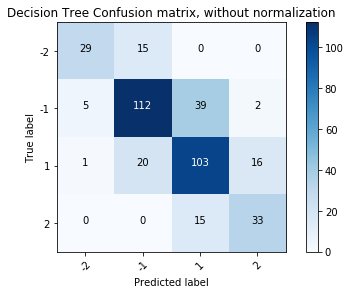

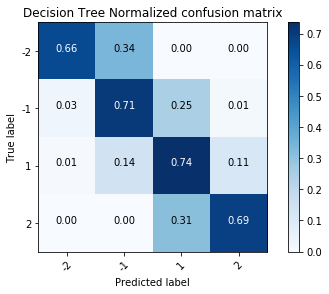

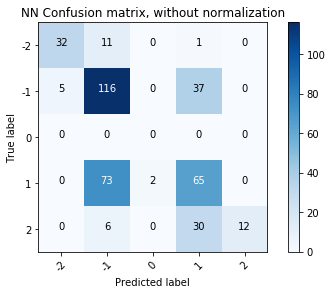

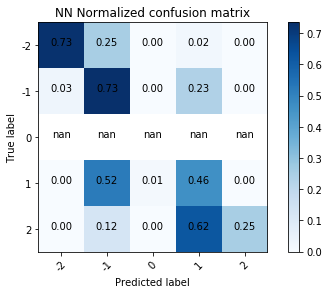

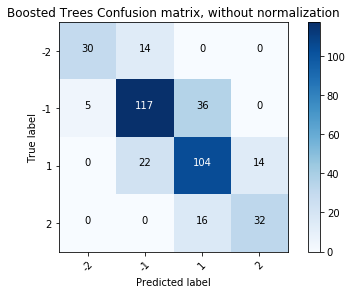

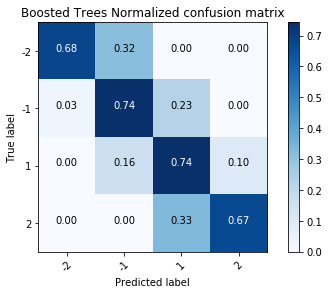

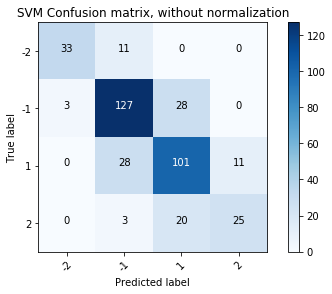

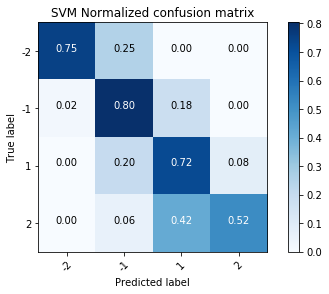

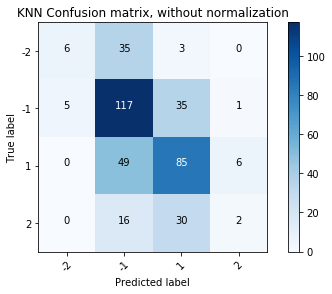

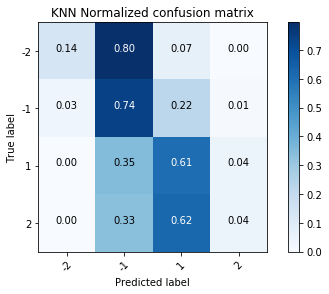

In [14]:
class_names = [-2, -1, 1, 2]
NN_class_names = [-2, -1, 0, 1, 2]

DT_cnf_matrix = confusion_matrix(Y_test, DT_Ypreds)
np.set_printoptions(precision=2)

####################################################################

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(DT_cnf_matrix, classes=class_names,
                      title='Decision Tree Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(DT_cnf_matrix, classes=class_names, normalize=True,
                      title='Decision Tree Normalized confusion matrix')
####################################################################

NN_cnf_matrix = confusion_matrix(Y_test, NN_Ypreds)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(NN_cnf_matrix, classes=NN_class_names,
                      title='NN Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(NN_cnf_matrix, classes=NN_class_names, normalize=True,
                      title='NN Normalized confusion matrix')
####################################################################

Boost_cnf_matrix = confusion_matrix(Y_test, Boost_Ypreds)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(Boost_cnf_matrix, classes=class_names,
                      title='Boosted Trees Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(Boost_cnf_matrix, classes=class_names, normalize=True,
                      title='Boosted Trees Normalized confusion matrix')
####################################################################

SVM_cnf_matrix = confusion_matrix(Y_test, SVM_Ypreds)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(SVM_cnf_matrix, classes=class_names,
                      title='SVM Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(SVM_cnf_matrix, classes=class_names, normalize=True,
                      title='SVM Normalized confusion matrix')
####################################################################
KNN_cnf_matrix = confusion_matrix(Y_test, KNN_Ypreds)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(KNN_cnf_matrix, classes=class_names,
                      title='KNN Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(KNN_cnf_matrix, classes=class_names, normalize=True,
                      title='KNN Normalized confusion matrix')


plt.show()

In [15]:
#from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

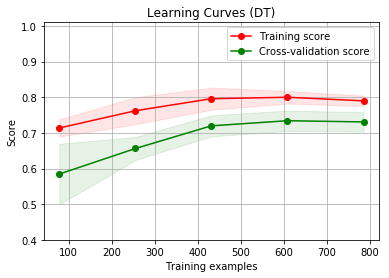

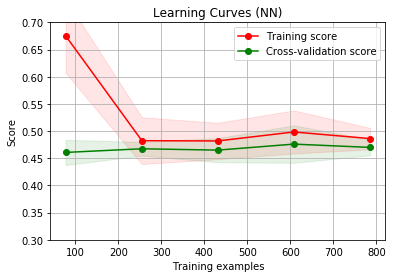

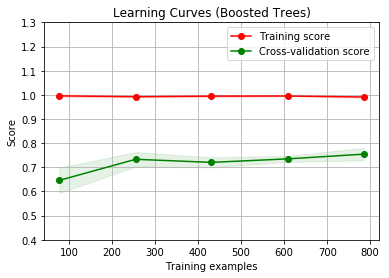

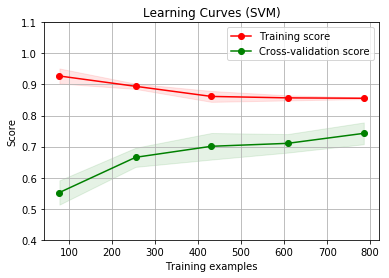

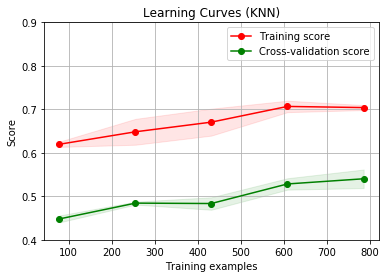

In [16]:
title = "Learning Curves (DT)"

plot_learning_curve(DT, title, X, Y, ylim=(0.4, 1.01))
####################################################################

title = "Learning Curves (NN)"
plot_learning_curve(NN, title, X, Y, (0.3, 0.7))

####################################################################

title = "Learning Curves (Boosted Trees)"
plot_learning_curve(Boost, title, X, Y, (0.4, 1.3))

####################################################################

title = "Learning Curves (SVM)"
plot_learning_curve(SVM, title, X, Y, (0.4, 1.1))
####################################################################

title = "Learning Curves (KNN)"
plot_learning_curve(KNN, title, X, Y, (0.4, 0.9))
####################################################################

plt.show()